
<h1><center>In Vino Veritas</center></h1>
<h2><center> <span style="font-weight:normal"><font color='#e42618'> Finding truth in wine data</font>  </span></center></h2>


<h3><center><font color='gray'>JONAS GOTTAL</font></center></h3>




<h4>Project scope</h4>

In 'Vino Veritas' is an old Latin phrase that means 'in wine, there is truth'. And we would like to obtain said truth in wine. What is objectively good wine and how is it influenced by the weather? The Wine Spectators official vintage charts are used as an objective measure for good wine, which is enriched by wine-specific features from public weather data.
<br>

---
---



# Enrichment of Weather Data
We now merge the weather data from meteostat with our regions.
(An upcoming project will be a comparison of meteostat vs open-meteo!)

In [2]:
import numpy as np 
import pandas as pd
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

from datetime import datetime
from meteostat import  Daily, Stations

import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_48601/3982447992.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# function to find the coordinate of a given city  
def findGeocode(city): 
       
    # try and catch is used to overcome the exception thrown by geolocator 
    try:  
        geolocator = Nominatim(user_agent="Wine-Terroir") 
        time.sleep(2)
        return geolocator.geocode(city, language='en') 
      
    except GeocoderTimedOut: 
        time.sleep(5)
          
        return findGeocode(city)     


In [4]:
# make def to return latitude and longitude for a city given a country (more reliable because sometimes the same city name exists in different countries)
def get_lat_long(city, country):
    if findGeocode(city) != None: 
        if findGeocode(city).raw["display_name"].split(", ")[-1] == country:
            return findGeocode(city).latitude, findGeocode(city).longitude
        #return findGeocode(city).latitude, findGeocode(city).longitude
        else:
            # open csv file and append the data city to clean it later
            with open('log.csv', 'a') as f:
                # format: City: "city", Country: "country", Date: "date" (only date, not time)
                f.write("City: " + city + ", Country: " + country + ", Date: " +str(datetime.today().strftime('%d-%m-%Y')) + '\n')
            return np.nan, np.nan
    else:
        # open csv file and append the data city to clean it later
        with open('log.csv', 'a') as f:
            # format: City: "city", Country: "country", Date: "date" (only date, not time)
            f.write("City: " + city + ", Country: " + country + ", Date: " +str(datetime.today().strftime('%d-%m-%Y')) + '\n')
        return np.nan, np.nan

we also average the $n$ nearest stations for a more robust and denser data set.

In [5]:
# average a df per column based on a multiindex if its non empty
def average_df(df):
    if not df.empty:
        df = df.groupby(level=1).mean()
    return df

# make def to get data based on a city and year from the n nearest stations
def get_weather(lat, lon, year, n):
    start = datetime(int(year), 1, 1)
    end = datetime(int(year), 12, 31)

    #lat, lon = get_lat_long(city,country)
        # check if not nan
    #if np.isnan(lat) or np.isnan(lon):
    #    # break if nan
    #    return np.nan
    #else:
    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(n)
    data = Daily(station, start, end)
    data = data.fetch()
    return average_df(data)

### Reduce to growth period

In [6]:
# get df for certain time frame based on index
def get_growth_period(df, start, end):
    return df.loc[start:end]
#Growth period: may 11th - september 20th 
#https://en.wikipedia.org/wiki/Harvest_(wine)
#df = get_growth_period(df, '2019-03-11', '2019-09-20')

### get volatility

In [7]:
# get volatility of a single column
def get_volatility(df, column):
    return df[column].std()/df[column].mean()


### Longest drought

In [8]:
# get the longest consecutive sequence of a value in a df
def longest_sequence(df, column, value):
    return df[column].eq(value).astype(int).groupby(df[column].ne(value).cumsum()).sum().max()


### Longest rain period

In [9]:
# get the longest consecutive sequence of the absence (!) of a value in a df
# this is the longest sequence of days with rain
def longest_sequence_no(df, column, value):
    return df[column].ne(value).astype(int).groupby(df[column].eq(value).cumsum()).sum().max()

### Avg Rain

In [10]:
#Vines need between 400 and 600 mm of rain per year. 
#A regular supply of water throughout the growth cycle is needed for a high quality crop.
#https://www.idealwine.info/conditions-necessary-great-wine-part-12/
# get the avg of the column prcp for a df
def get_avg_prcp(df):
    return df['prcp'].mean()

### No of Days above 35 degrees 

In [11]:
#At temperatures below 10°C and above 35°C, photosynthesis will be disrupted and vines will not grow properly.
# count number of rows in a df column tmax above a threshold
def count_above(df, column, threshold):
    return df[df[column] > threshold][column].count()

### number of days below 10 degrees


In [12]:
# count number of rows in a df column tmax under a threshold

def count_under(df, column, threshold):
    return df[df[column] < threshold][column].count()

### coulure wspd

In [13]:
#strong wind around june --> coulure 
# get the avg of the column wspd for a df
def get_avg_wspd(df):
    try:
        year = df.index[0].year
        df = get_growth_period(df, f'{year}-05-15', f'{year}-07-15')
        return df['wspd'].mean()
    except:
        return np.nan

### May July Rain

In [14]:
#Too much rain during the May-July period --> diseases such as mildew or oidium
# sum the column prcp for a df
def get_sum_prcp(df):
     try: 
         year = df.index[0].year
         df = get_growth_period(df, f'{year}-05-15', f'{year}-07-15')
         return df['prcp'].sum()
     except:
         return np.nan

## Combined Features
```
Temp Vola: get_volatility(df, 'tavg')
Rain Vola: get_volatility(df, 'prcp')
Longest drought: longest_sequence(df, 'prcp', 0)
Longest Rain: longest_sequence_no(df, 'prcp', 0) 
Avg Rain: get_avg_prcp(df)
NoDays35: count_above(df, 'tmax', 35)
NoDays10: count_under(df, 'tmin', 10)
NoDays0: count_under(df, 'tmin', 0)
ColourWspd: get_avg_wspd(df)
MayJulyRain: get_sum_prcp(df)
```

In [15]:
# combine all function in one function

def get_weather_features(lat, lon, year, n):
    raw = get_weather(lat, lon, year, n)
    if raw is np.nan:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    else:
        df = get_growth_period(raw, f'{year}-03-11', f'{year}-09-20')
        return pd.Series([get_volatility(df, 'tavg'), get_volatility(df, 'prcp'), longest_sequence(df, 'prcp', 0), longest_sequence_no(df, 'prcp', 0), get_avg_prcp(df), count_above(df, 'tmax', 35), count_under(df, 'tmin', 10), count_under(df, 'tmin', 0), get_avg_wspd(df), get_sum_prcp(df)])

# Merge

In [65]:
# load drafts/df_out.csv
df = pd.read_csv('data/wine_data.csv')

In [66]:
df.head()

,Vintage,Score,Drink Window,Description,Country,Region,Variety
0,2021,93–97,NYR,As vines struggled to ripen their fruit at the...,United States,Napa,Cabernet
1,2020,87,Drink,The setup—wet winter into dry spring—was ideal...,United States,Napa,Cabernet
2,2019,97,Hold,A wet spring resulted in less overt tannic str...,United States,Napa,Cabernet
3,2018,99,Hold,A wet winter provided sufficient water through...,United States,Napa,Cabernet
4,2017,92,Drink or hold,"Drought broke over the winter, with lots of ve...",United States,Napa,Cabernet


In [67]:
len(df)

1432

In [68]:
# unfortunately some data is clean but the geopy API doesnt recognize it, so we adjust three more regions
#Barossa and McLaren Vale, Australia --> Adelaide
#Côtes de Nuits, France -> Vougeot
#Douro Valley, Portugal --> Coimbra

df.loc[(df['Region'] == 'Barossa and McLaren Vale'), 'Region'] = 'Adelaide'
df.loc[(df['Region'] == 'Côtes de Nuits'), 'Region'] = 'Vougeot'
df.loc[(df['Region'] == 'Douro Valley'), 'Region'] = 'Coimbra'


## Coordinates (lat, long)

In [69]:
# unique country + region tuples
unique = df[['Country', 'Region']].drop_duplicates()
unique

,Country,Region
0,United States,Napa
31,United States,Carneros Valley
57,United States,California
83,United States,Oregon
107,United States,Washington
152,Argentina,Mendoza
197,Australia,Adelaide
219,Australia,Victoria
259,Austria,Austria
317,Chile,Chile


One might need to run it twice - depending on the servers.

In [70]:
import csv
import pandas as pd

# Open the CSV file
with open('data/pairs.csv', 'r+') as f:
    # Create a CSV reader
    reader = csv.reader(f)
    # Read the existing pairs into a set
    existing_pairs = set(tuple(row) for row in reader)

    # Go to the end of the file to append new data
    f.seek(0, 2)
    writer = csv.writer(f)

    # Iterate over the rows of the DataFrame
    for _, row in unique.iterrows():
        pair = (row['Region'], row['Country'])
        # If the pair is not in the existing pairs
        exists = any(ex_pair[0:2] == pair for ex_pair in existing_pairs)

        if not exists:
            # Make the API call
            lat, lon = get_lat_long(row['Region'], row['Country'])
            # Write the pair and the result to the CSV file
            writer.writerow(pair + (lat,lon,))

In [71]:
# Load the CSV file into another DataFrame
df_pairs = pd.read_csv('data/pairs.csv', names=['Region', 'Country', 'Lat', 'Lon'], header=None)

# Merge the two DataFrames on the country and region columns
df = pd.merge(df, df_pairs, on=['Region', 'Country'], how='left')

# drop true duplicates
df = df.drop_duplicates()

In [72]:
df.head()

,Vintage,Score,Drink Window,Description,Country,Region,Variety,Lat,Lon
0,2021,93–97,NYR,As vines struggled to ripen their fruit at the...,United States,Napa,Cabernet,38.297137,-122.285529
1,2020,87,Drink,The setup—wet winter into dry spring—was ideal...,United States,Napa,Cabernet,38.297137,-122.285529
2,2019,97,Hold,A wet spring resulted in less overt tannic str...,United States,Napa,Cabernet,38.297137,-122.285529
3,2018,99,Hold,A wet winter provided sufficient water through...,United States,Napa,Cabernet,38.297137,-122.285529
4,2017,92,Drink or hold,"Drought broke over the winter, with lots of ve...",United States,Napa,Cabernet,38.297137,-122.285529


In [73]:
len(df)

1432

## Weather

In [75]:
# Open the CSV file
with open('data/weather.csv', 'r+') as f:
    # Create a CSV reader
    reader = csv.reader(f)
    # Read the existing pairs into a set
    existing_pairs = set(tuple(row) for row in reader)

    # Go to the end of the file to append new data
    f.seek(0, 2)
    writer = csv.writer(f)

    # Iterate over the rows of the DataFrame
    for _, row in df.iterrows():
        pair = (row['Vintage'], row['Lat'], row['Lon'])
        # If the pair is not in the existing pairs
        exists = any(ex_pair[0:3] == pair for ex_pair in existing_pairs)

        if not exists:
            # Make the API call
            Vola_Temp,	Vola_Rain,	Longest_Dry,	Longest_Wet,	Avg_Rain,	Count_above35,	Count_under10,	Count_under0,	Coulure_Wind,	June_Rain = get_weather_features(row['Lat'], row['Lon'], row['Vintage'], 5)
            # Write the pair and the result to the CSV file
            writer.writerow(pair + (Vola_Temp,	Vola_Rain,	Longest_Dry,	Longest_Wet,	Avg_Rain,	Count_above35,	Count_under10,	Count_under0,	Coulure_Wind,	June_Rain,))

In [84]:
#df[["Vola_Temp", "Vola_Rain", "Longest_Dry", "Longest_Wet", "Avg_Rain", "Count_above35", "Count_under10", "Count_under0", "Coulure_Wind", "June_Rain"]] = df.apply(lambda row: get_weather_features(row['Lat'], row['Lon'], row['Vintage'], 5), axis=1)
# apply function doesn't work since there are many points of failure in free API calls

# Load the CSV file into another DataFrame
df_weather = pd.read_csv('data/weather.csv', names=['Vintage', 'Lat', 'Lon', "Vola_Temp", "Vola_Rain", "Longest_Dry", "Longest_Wet", "Avg_Rain", "Count_above35", "Count_under10", "Count_under0", "Coulure_Wind", "June_Rain"], header=None)
# drop true duplicates
df_weather = df_weather.drop_duplicates()
# Merge the two DataFrames on the country and region columns
df = pd.merge(df, df_weather, on=['Vintage', 'Lat', 'Lon'], how='left')
df.head()

,Vintage,Score,Drink Window,Description,Country,Region,Variety,Lat,Lon,Vola_Temp,Vola_Rain,Longest_Dry,Longest_Wet,Avg_Rain,Count_above35,Count_under10,Count_under0,Coulure_Wind,June_Rain
0,2021,93–97,NYR,As vines struggled to ripen their fruit at the...,United States,Napa,Cabernet,38.297137,-122.285529,0.212736,7.168308,29.0,4.0,0.149378,10.0,73.0,0.0,17.094839,1.18
1,2020,87,Drink,The setup—wet winter into dry spring—was ideal...,United States,Napa,Cabernet,38.297137,-122.285529,0.251209,12.225392,73.0,3.0,0.027841,17.0,57.0,1.0,15.233226,4.50
2,2019,97,Hold,A wet spring resulted in less overt tannic str...,United States,Napa,Cabernet,38.297137,-122.285529,0.219853,6.959674,58.0,4.0,0.315730,11.0,52.0,0.0,15.071129,30.70
3,2018,99,Hold,A wet winter provided sufficient water through...,United States,Napa,Cabernet,38.297137,-122.285529,0.213956,6.207925,67.0,7.0,0.403734,3.0,68.0,0.0,16.054113,1.25
4,2017,92,Drink or hold,"Drought broke over the winter, with lots of ve...",United States,Napa,Cabernet,38.297137,-122.285529,0.221765,13.114877,54.0,4.0,0.000872,19.0,46.0,0.0,15.661129,0.00


In [85]:
len(df)

1473

<Axes: >

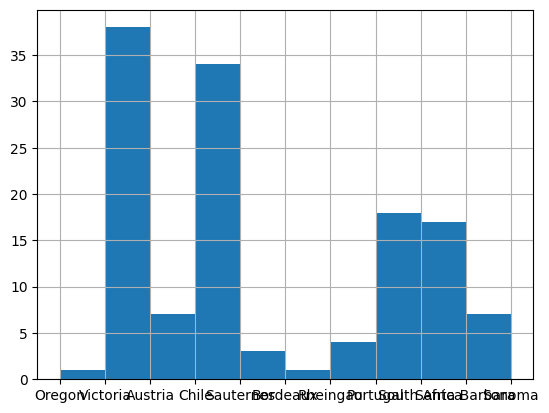

In [88]:
# show histogram of Vintages where Vola_temp is nan
df[df['Vola_Temp'].isna()]['Region'].hist()

In [89]:
# drop columns lat and lon
df = df.drop(['Lat', 'Lon'], axis=1)
df.head()   

,Vintage,Score,Drink Window,Description,Country,Region,Variety,Vola_Temp,Vola_Rain,Longest_Dry,Longest_Wet,Avg_Rain,Count_above35,Count_under10,Count_under0,Coulure_Wind,June_Rain
0,2021,93–97,NYR,As vines struggled to ripen their fruit at the...,United States,Napa,Cabernet,0.212736,7.168308,29.0,4.0,0.149378,10.0,73.0,0.0,17.094839,1.18
1,2020,87,Drink,The setup—wet winter into dry spring—was ideal...,United States,Napa,Cabernet,0.251209,12.225392,73.0,3.0,0.027841,17.0,57.0,1.0,15.233226,4.50
2,2019,97,Hold,A wet spring resulted in less overt tannic str...,United States,Napa,Cabernet,0.219853,6.959674,58.0,4.0,0.315730,11.0,52.0,0.0,15.071129,30.70
3,2018,99,Hold,A wet winter provided sufficient water through...,United States,Napa,Cabernet,0.213956,6.207925,67.0,7.0,0.403734,3.0,68.0,0.0,16.054113,1.25
4,2017,92,Drink or hold,"Drought broke over the winter, with lots of ve...",United States,Napa,Cabernet,0.221765,13.114877,54.0,4.0,0.000872,19.0,46.0,0.0,15.661129,0.00


In [90]:
len(df)

1473

In [91]:
# save as CSV file
df.to_csv('data/merged_data.csv', index=False)